In [ ]:
import numpy as np
import re
import gzip

Dataset = []
with gzip.open ('reviews_data.txt.gz', 'rb') as f:
    for i,line in enumerate (f):
        Dataset.append(line)

# Cleaning the Dataset

In [0]:
Cleaned_Dataset=[]
for x in Dataset:
    #print(x)
    x = re.sub(r"(?:Jan|Feb|Mar|Apr|May|Jun|July|Aug|Sep|Oct|Nov|Dec)[\ ][0-9]{1,2}[\ ][0-9]{4}","",str(x))
    x = re.sub(r"[\?]{2,}","",str(x))
    x = re.sub("[\\\\][t|r|n]","",str(x))
    
    Cleaned_Dataset.append(x)


# Tokenize: 
For changing the sentences to tokens , for example "I am studying NLP" -> ["I","am","studying","NLP"]
# Mappings:
To be able to retrieve the id of words as we need to change words to numbers to be understandable for the neural network, and each number will be corresponding to its word vector
# Create Dataset:
To create the skipgram model suitable database. Each input word should correspond to its neighbouring window size word, for example if window size = 2 taking the previous and next two words with the center word as the input and window words as label : "I am studying NLP and ML" -> ["I","am"] ["I","studying"] ["studying","I"] ["studying","am"] ["studying","NLP"] ["studying","and"] ["NLP","am"] ["NLP","studying"] ["NLP","and"] ["NLP","ML"] ["ML","and"] ["ML","NLP"]


In [0]:
def tokenize(sentences):
    tokens=[]
    for line in sentences:
        for words in line.split(" "):
            tokens.append(words)
    return tokens

def mappings(tokens):
    word2id = dict()
    id2word = dict()
  
    for i,word in enumerate(set(tokens)):
    
        word2id[word]=i
        id2word[i]=word
    
    return word2id,id2word

  
def Create_Dataset(word2id,tokens,window_size):
  
    X,Y = [],[]
    N = len(tokens)
    for i,word in enumerate(tokens):
        window = list(range(max(0,i-2),i)) + list(range(i+1,min(i+2+1,N)))
        for j in window:
            X.append(word2id[tokens[i]])
            Y.append(word2id[tokens[j]])
            
    X = np.array(X)
    X = np.expand_dims(X,axis=0)
    Y = np.array(Y)
    Y = np.expand_dims(Y,axis=0)
    return X,Y        
    

# Create wordvec:
Create the center word embeddings matrix
# Create contextvec:
Create the context word embeddings matrix

In [1]:
def create_wordvec(Vocab_size,Embed_size):
  
    word2vec = np.random.randn(Vocab_size,Embed_size)*0.01
    
    return word2vec
  
def create_contextvec(Vocab_size,Embed_size):
    
    contextvec = np.random.randn(Embed_size,Vocab_size)*0.01
    
    return contextvec
  
def initialize_vectors(Vocab_size,Embed_size):
    
    parameters = {}
    w2v = create_wordvec(Vocab_size,Embed_size)
    w_embed = create_contextvec(Embed_size,Vocab_size)
    parameters['w2v'] = w2v
    parameters['w_embed']=w_embed
    return parameters

# Get center vecs:
Return center word vectors according to their index in the dictionary
# Forward pass
The forward pass of the our one layer network, where the center word is dot producted with the all the context words.
# Softmax
Turn the output to probabilities

In [0]:
def get_center_vecs(inds,parameters):
    #print(inds.shape)
    inds = inds.flatten()
    w2v = parameters['w2v']
    center_word_vectors = w2v[inds,:]
    
    return center_word_vectors
  
def forward_pass(parameters,inds):
    caches = {}
    center_word_vectors = get_center_vecs(inds,parameters)
    
    outside_matrix = parameters['w_embed']
    z = np.dot(outside_matrix,center_word_vectors.T)
    
    caches['inds']=inds
    caches['w2v'] = center_word_vectors
    caches['w_embed'] = outside_matrix
    caches['softmax_out']= softmax(z)
    
    return z,caches

def softmax(Z):
   return np.divide(np.exp(Z)+0.001, np.sum(np.exp(Z), axis=0, keepdims=True) + 0.001)

In [0]:
def cross_entropy_loss(z,Y):
    m = z.shape[1]
    cost = -(1 / m) * np.sum(np.sum(Y * np.log(z + 0.001), axis=0, keepdims=True), axis=1)
    return cost

# Derivative
Formulas for the derivatives of the network.

\begin{equation}
\frac{\delta Loss}{\delta CenterVector} = \frac{\delta Loss}{\delta Z} \frac{\delta Z}{\delta CenterVector}
\\\\
\frac{\delta Loss}{\delta ContextVector} = \frac{\delta Loss}{\delta Z} \frac{\delta Z}{\delta ContextVector}
 \end{equation}

In [0]:
def softmax_derivative(Y,caches):
    z = caches['softmax_out']
    return z-Y
  
def vectors_derivative(caches,Y):
    gradients = {}
    
    outside = caches['w_embed']
    word_vec = caches['w2v']
    m = word_vec.shape[1]
    softmax_out_derivative = softmax_derivative(Y,caches)
    center_derivative = (1/m)*np.dot(softmax_out_derivative,word_vec)
    outside_derivative = np.dot(outside.T,softmax_out_derivative)
    gradients['z'] = softmax_out_derivative
    gradients['c'] = center_derivative
    gradients['o'] = outside_derivative
    return gradients
  
def backward_pass(parameters,caches,gradients,learning_rate,Y_batch):
    center_derivative = gradients['c']
    outside_derivative = gradients['o']
    inds = caches['inds']
    #print(inds)
    parameters['w2v'][inds.flatten(),:] = parameters['w2v'][inds.flatten(),:]-learning_rate*center_derivative[inds.flatten(),:]
    #print(parameters['w_embed'].shape)
    #print(outside_derivative.shape)
    parameters['w_embed'][Y_batch.flatten(),:]-=learning_rate*outside_derivative.T

In [0]:
from collections import Counter
def train(learning_rate,Embed_size,window_size,sentences,epochs,batch_size):
  
    tokens = tokenize(sentences[:1000])
    c = Counter(tokens)
    Vocab_size = len(c)
    print(Vocab_size)
    word2id,id2word = mappings(tokens)
    X,Y = Create_Dataset(word2id,tokens,window_size)
    parameters = initialize_vectors(Vocab_size,Embed_size)
    #print(X.shape)
    
    for epoch in range(epochs):
        m = X.shape[1]
        batch_inds = list(range(0,m,batch_size))
        #print(batch_inds)
        loss = 0
        for i in batch_inds:
            
            X_batch = X[:,i:i+batch_size]
            Y_batch = Y[:,i:i+batch_size]
            
            forward_result,caches = forward_pass(parameters,X_batch)
            
            z = softmax(forward_result)
            print(z)
            
            loss += cross_entropy_loss(z,Y_batch)
            #if(i%10==0):
              #print(loss)
            gradients = vectors_derivative(caches,Y_batch)
            backward_pass(parameters,caches,gradients,learning_rate,Y_batch)
        if epoch%2==0:
           print(loss)
        

In [49]:
train(1,50,3,Cleaned_Dataset,20,32)

20110
[[4.98045486e-05 4.98045486e-05 4.97435333e-05 ... 4.97706005e-05
  4.97706005e-05 4.97706005e-05]
 [4.98957093e-05 4.98957093e-05 4.97995149e-05 ... 4.97700497e-05
  4.97700497e-05 4.97700497e-05]
 [4.98087867e-05 4.98087867e-05 4.96862964e-05 ... 4.97219231e-05
  4.97219231e-05 4.97219231e-05]
 ...
 [4.97103708e-05 4.97103708e-05 4.98142434e-05 ... 4.97792775e-05
  4.97792775e-05 4.97792775e-05]
 [4.97648647e-05 4.97648647e-05 4.97890233e-05 ... 4.97648875e-05
  4.97648875e-05 4.97648875e-05]
 [4.98285022e-05 4.98285022e-05 4.97634682e-05 ... 4.97713842e-05
  4.97713842e-05 4.97713842e-05]]
[[0.00000000e+00 4.98426100e-05 4.98426100e-05 ... 4.97400782e-05
  4.97400782e-05 4.97400782e-05]
 [0.00000000e+00 4.97823602e-05 4.97823602e-05 ... 4.98116354e-05
  4.98116354e-05 4.98116354e-05]
 [0.00000000e+00 4.98008311e-05 4.98008311e-05 ... 4.98260223e-05
  4.98260223e-05 4.98260223e-05]
 ...
 [0.00000000e+00 4.97884736e-05 4.97884736e-05 ... 4.98259924e-05
  4.98259924e-05 4.9825992

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide


[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[nan nan nan ... nan nan nan]
 [nan nan

KeyboardInterrupt: ignored

In [0]:
tokens = tokenize(Cleaned_Dataset[:100])
word_to_id, id_to_word = mapping(tokens)
X, Y = generate_training_data(tokens, word_to_id, 3)
vocab_size = len(id_to_word)
m = Y.shape[1]
# turn Y into one hot encoding
Y_one_hot = np.zeros((vocab_size, m))
Y_one_hot[Y.flatten(), np.arange(m)] = 1

Cost after epoch 0: 5521.543001365725
Cost after epoch 2: 5516.7978653259
Cost after epoch 4: 5324.426327714323
Cost after epoch 6: 5166.553481733751
Cost after epoch 8: 5070.635202629106
training time: 0:09:48.626511


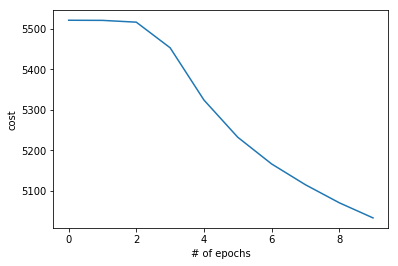

In [14]:
paras = skipgram_model_training(X, Y_one_hot, vocab_size, 50, 0.05, 10, batch_size=128, parameters=None, print_cost=True)